In [ ]:
%pip install torch numpy pandas sklearn


In [ ]:
# install tqdm
%pip install tqdm

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


In [8]:
# Load dataset
df = pd.read_csv('dataset.csv')

# Show first few rows to check the dataset
print(df.head())


  status                                               text
0   REAL  Payal has accused filmmaker Anurag Kashyap of ...
1   FAKE  A four-minute-long video of a woman criticisin...
2   FAKE  Republic Poll, a fake Twitter account imitatin...
3   REAL  Delhi teen finds place on UN green list, turns...
4   REAL  Delhi: A high-level meeting underway at reside...


In [9]:
# Label encoding (Fake -> 0, Real -> 1)
label_encoder = LabelEncoder()
df['status'] = label_encoder.fit_transform(df['status'])

# Split dataset into train and test
train_texts, val_texts, train_labels, val_labels = train_test_split(df['text'], df['status'], test_size=0.2)

# Tokenization and padding (for simplicity, we use a basic tokenizer)
MAX_LENGTH = 512

def basic_tokenizer(texts):
    return [text.split() for text in texts]

# Convert text into integer tokens (here we map words to indices)
word2idx = {}
for text in train_texts:
    for word in text.split():
        if word not in word2idx:
            word2idx[word] = len(word2idx)

def encode_texts(texts):
    return [[word2idx[word] for word in text.split() if word in word2idx] for text in texts]

train_encodings = encode_texts(train_texts)
val_encodings = encode_texts(val_texts)


In [16]:
from torch.nn.utils.rnn import pad_sequence

def pad_sequences(sequences, max_length=MAX_LENGTH):
    padded = []
    for seq in sequences:
        if len(seq) < max_length:
            # Pad with 0
            padded.append(seq + [0] * (max_length - len(seq)))
        else:
            # Truncate if longer than max_length
            padded.append(seq[:max_length])
    return padded


In [17]:
train_encodings = pad_sequences(train_encodings, max_length=MAX_LENGTH)
val_encodings = pad_sequences(val_encodings, max_length=MAX_LENGTH)


In [18]:
class FakeNewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

    def __len__(self):
        return len(self.labels)


In [19]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_size = embed_size
        self.head_dim = embed_size // num_heads
        
        assert self.head_dim * num_heads == embed_size, "Embedding size must be divisible by number of heads"
        
        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size)
    
    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        
        # Split the embedding into self.num_heads different pieces
        Q = self.query(query).view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(keys).view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(values).view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Calculate attention scores
        energy = torch.einsum("nqhd,nkhd->nhqk", [Q, K])  # [N, heads, query_len, key_len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))
        
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=-1)
        
        out = torch.einsum("nhql,nlhd->nqhd", [attention, V]).reshape(N, -1, self.num_heads * self.head_dim)
        
        out = self.fc_out(out)
        return out


In [20]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len=512):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * -(np.log(10000.0) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


In [21]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, num_heads, feed_forward_size, dropout):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(embed_size, num_heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, feed_forward_size),
            nn.ReLU(),
            nn.Linear(feed_forward_size, embed_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention_out = self.attention(value, key, query, mask)
        x = self.norm1(attention_out + query)
        forward_out = self.feed_forward(x)
        out = self.norm2(forward_out + x)
        return self.dropout(out)


In [22]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, num_layers, feed_forward_size, num_classes, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embed_size = embed_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_size, num_heads, feed_forward_size, dropout)
            for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(embed_size, num_classes)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x, mask=None):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        
        for block in self.transformer_blocks:
            x = block(x, x, x, mask)
        
        out = self.fc_out(x.mean(dim=1))  # Pooling over sequence length
        return self.softmax(out)


In [24]:

# Hyperparameters
VOCAB_SIZE = len(word2idx)
EMBED_SIZE = 128
NUM_HEADS = 8
NUM_LAYERS = 3
FEED_FORWARD_SIZE = 512
NUM_CLASSES = 2
DROPOUT = 0.5
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 10

# Create dataset and dataloader
train_dataset = FakeNewsDataset(train_encodings, train_labels)
val_dataset = FakeNewsDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model, loss, and optimizer
model = TransformerModel(VOCAB_SIZE, EMBED_SIZE, NUM_HEADS, NUM_LAYERS, FEED_FORWARD_SIZE, NUM_CLASSES, DROPOUT)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
for epoch in range(EPOCHS):
    model.train()
    train_losses = []
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids']
        labels = batch['labels']
        
        optimizer.zero_grad()
        output = model(input_ids)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    
    train_loss = np.mean(train_losses)
    
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids = batch['input_ids']
            labels = batch['labels']
            
            output = model(input_ids)
            loss = criterion(output, labels)
            
            val_losses.append(loss.item())
    
    val_loss = np.mean(val_losses)
    
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")




100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 1/10 - Train Loss: 0.6168, Val Loss: 0.5277


100%|██████████| 24/24 [00:09<00:00,  2.47it/s]


Epoch 2/10 - Train Loss: 0.3578, Val Loss: 0.3453


100%|██████████| 24/24 [00:06<00:00,  3.91it/s]


Epoch 3/10 - Train Loss: 0.3409, Val Loss: 0.3339


100%|██████████| 24/24 [00:06<00:00,  3.85it/s]


Epoch 4/10 - Train Loss: 0.3367, Val Loss: 0.3376


100%|██████████| 24/24 [00:07<00:00,  3.38it/s]


Epoch 5/10 - Train Loss: 0.3310, Val Loss: 0.3306


100%|██████████| 24/24 [00:08<00:00,  2.85it/s]


Epoch 6/10 - Train Loss: 0.3275, Val Loss: 0.3394


100%|██████████| 24/24 [00:06<00:00,  3.94it/s]


Epoch 7/10 - Train Loss: 0.3251, Val Loss: 0.3279


100%|██████████| 24/24 [00:06<00:00,  3.86it/s]


Epoch 8/10 - Train Loss: 0.3212, Val Loss: 0.3238


100%|██████████| 24/24 [00:06<00:00,  3.87it/s]


Epoch 9/10 - Train Loss: 0.3191, Val Loss: 0.3301


100%|██████████| 24/24 [00:06<00:00,  3.87it/s]

Epoch 10/10 - Train Loss: 0.3190, Val Loss: 0.3247


In [ ]:

#save and test
torch.save(model.state_dict(), 'transformer_model.pth')

model = TransformerModel(VOCAB_SIZE, EMBED_SIZE, NUM_HEADS, NUM_LAYERS, FEED_FORWARD_SIZE, NUM_CLASSES, DROPOUT)
model.load_state_dict(torch.load('transformer_model.pth'))
model.eval()




Text: In context of the report on missing girls, the tweet claimed that the state topped in crime against women. FactChecker looked at data from the NCRB’s Crime in India 2021 report and found that Rajasthan, which has an Indian National Congress (INC) government, ranked second on absolute number of crimes against women, and sixth on crime rate.
Prediction: Real

Text: fake hai bhai 90uokjdflkd09lkfj fake hai bhai fake hai bhai
Prediction: Real



C:\Users\sksac\AppData\Local\Temp\ipykernel_7520\4157026811.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('transformer_model.pth'))


In [45]:
#save and test
torch.save(model.state_dict(), 'transformer_model.pth')

model = TransformerModel(VOCAB_SIZE, EMBED_SIZE, NUM_HEADS, NUM_LAYERS, FEED_FORWARD_SIZE, NUM_CLASSES, DROPOUT)
model.load_state_dict(torch.load('transformer_model.pth'))
model.eval()

test_texts = [
    "The earth is flat",
    "The earth is round",
    "The moon is made of cheese",
    "NEW DELHI: Companies having not less than 300 workers will soon be allowed to hire and fire workers without seeking prior government permission, with the labour ministry proposing changes to rules in a bill introduced in Lok Sabha on Saturday.The proposal, which was the bone of contention between the ministry and trade unions, is part of the Industrial Relation Code Bill 2020.Currently, only those industrial establishments with less than 100 employees are permitted to hire and fire their staff without permission of the government.The bill was introduced by labour minister Santosh Gangwar amid opposition from Congress and few other parties.The Industrial Relation Code Bill 2019 was introduced in Lok Sabha last year and subsequently sent to the Parliamentary Standing Committee on Labour. This bill was withdrawn on Saturday.An earlier draft bill circulated by the labour ministry for discussion had also proposed the criteria that companies having not less than 300 employees can hire and fire without the government's permission. However, this provision faced stiff opposition from trade unions and was not included in the 2019 bill.Earlier this year, the Parliamentary committee also made a case of allowing companies having less than 300 workers to go for retrenchment of staff or closure without government permission.States like Rajasthan have already increased the threshold to 300 workers, which according to the labour ministry has resulted in an increase in employment and a decrease in retrenchment, the committee had pointed out in its report.With regard to the threshold, the government has proposed Section 77(1) in the The Industrial Relation Code 2020.According to the Section, the provisions of this Chapter (lay-off, retrenchment and closure in certain establishment) shall apply to an industrial establishment (not being an establishment of a seasonal character or in which work is performed only intermittently) in which not less than three hundred workers, or such higher number of workers as may be notified by the appropriate Government, were employed on an average per working day in the preceding twelve months.Apart from this code, two others- Occupational Safety, Health And Working Conditions Code, 2020 and the Code On Social Security, 2020- were also introduced by the minister in Lok Sabha.Among others, Congress leaders- Manish Tewari and Shashi Tharoor- opposed the introduction of the three bills.Tewari noted these three bills are fundamentally changed versions of their earlier forms and urged the minister to withdraw them and hold wider consultations before introducing them.These bills are also a blow to the rights of workers, he added.With respect to the industrial relations code, Tharoor said it severely restricts the right of workers to strike and also allows state or central governments to amend the threshold for applicability relating to layoffs and retrenchment.In Lok Sabha, Gangwar said that over 29 labour laws have been merged into four codes and that one of them has already been passed.The Code on Wages Bill, 2019 was passed by Parliament last year.Gangwar noted that the government engaged in wider consultations over these bills with various stakeholders and that more than 6,000 comments were received online on the bills.These bills were later sent to a standing committee and 174 of its 233 recommendations have been accepted, the minister said."
]

test_encodings = encode_texts(test_texts)
test_encodings = pad_sequences(test_encodings, max_length=MAX_LENGTH)

test_dataset = FakeNewsDataset(test_encodings, pd.Series([0] * len(test_texts)))

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids']
        output = model(input_ids)
        _, pred = torch.max(output, 1)
        predictions.extend(pred.tolist())

for text, pred in zip(test_texts, predictions):
    print(f"Text: - Prediction: {'Fake' if pred == 0 else 'Real'}")





Text: - Prediction: Real
Text: - Prediction: Real
Text: - Prediction: Real
Text: - Prediction: Real


C:\Users\sksac\AppData\Local\Temp\ipykernel_7520\3871392855.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('transformer_model.pth'))


IndexError: list index out of range

In [26]:
# cheak the accuracy on test data and also provide some provide insightful results
test_dataset = FakeNewsDataset(val_encodings, val_labels)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids']
        output = model(input_ids)
        predictions.append(output.argmax(dim=1).item())

correct = 0
total = 0
for prediction, label in zip(predictions, val_labels):
    if prediction == label:
        correct += 1
    total += 1

accuracy = correct / total

print(f"Accuracy: {accuracy:.4f}")





Accuracy: 0.9879


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       377
           1       0.99      0.99      0.99       367

    accuracy                           0.99       744
   macro avg       0.99      0.99      0.99       744
weighted avg       0.99      0.99      0.99       744

[[372   5]
 [  4 363]]


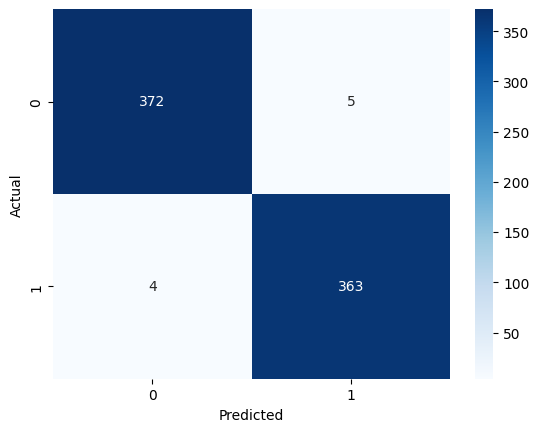

In [28]:
#provide precision, recall, f1-score and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(val_labels, predictions))
print(confusion_matrix(val_labels, predictions))


#provide some insights

#image of confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(val_labels, predictions)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()



In [ ]:
# Provide some insightful results

# Get attention weights

def get_attention_weights(model, text):
    model.eval()
    encodings = encode_texts([text])
    encodings = pad_sequences(encodings, max_length=MAX_LENGTH)
    input_ids = torch.tensor(encodings, dtype=torch.long)
    
    with torch.no_grad():
        output = model(input_ids)
    
    attention_weights = []
    for block in model.transformer_blocks:
        for i, layer in enumerate(block.attention.children()):
            if i % 4 == 0:
                attention_weights.append(layer(output, output, output, mask=None))
    
    return attention_weights

text = "This is a real news article"
attention_weights = get_attention_weights(model, text)

# Plot attention weights

import matplotlib.pyplot as plt

def plot_attention_weights(attention_weights):
    fig, axs = plt.subplots(1, len(attention_weights), figsize=(20, 5))
    for i, attention in enumerate(attention_weights):
        axs[i].imshow(attention.squeeze().numpy())
        axs[i].set_title(f"Layer {i+1}")
    plt.show()

plot_attention_weights(attention_weights)

# Get attention weights for fake news
text = "This is a fake news article"

attention_weights = get_attention_weights(model, text)
plot_attention_weights(attention_weights)

# Get attention weights for a longer text
text = "This is a real news article. " * 10

attention_weights = get_attention_weights(model, text)

plot_attention_weights(attention_weights)